# Draw the results of every train.

In [25]:
# Define a function, whose input is a list of json files.
# The json files each present a k-fold result for a single model.
# It contains:
# (1) The trainning and validation loss for each epoch.
# (2) The validation accuracy for each epoch.
# (3) The best test accuracy.
import json
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

def get_json_files(model_name):
    base_dir = 'models'
    return [os.path.join(base_dir, f"ica_exp_{model_name}_fold_{i}_metrics.json") for i in range(1, 11)]

def plot_training_results(model_name, save_path=None, smooth_factor=0.8):
    """
    Plot training and validation loss curves from multiple k-fold training results.
    
    Args:
        model_name (str, optional): Name of the model for the plot title
        save_path (str, optional): Path to save the generated plot
        smooth_factor (float, optional): Smoothing factor for curves (0 < factor < 1)
        
    Returns:
        list: Test accuracies from all files
    """
    json_files = get_json_files(model_name)

    # Lists to store data from all files
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    test_accs = []
    
    max_epochs = 0
    
    # Read data from all JSON files
    for file_path in json_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            # Extract data
            if 'train_losses' in data and 'val_losses' in data and 'train_accuracies' in data and 'val_accuracies' in data:
                train_loss = data['train_losses']
                val_loss = data['val_losses']
                train_acc = data['train_accuracies']
                val_acc = data['val_accuracies']
                
                # Update max epochs
                max_epochs = max(max_epochs, len(train_loss))
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
                
                # Extract test accuracy if available
                if 'test_acc' in data:
                    test_accs.append(data['test_acc'])
            else:
                print(f"Warning: Required data not found in {file_path}")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # If no valid data was found, return
    if not train_losses:
        print("No valid data found in the provided JSON files.")
        return []
    
    # Pad sequences to have the same length
    for i in range(len(train_losses)):
        if len(train_losses[i]) < max_epochs:
            train_losses[i] = train_losses[i] + [train_losses[i][-1]] * (max_epochs - len(train_losses[i]))
        if len(val_losses[i]) < max_epochs:
            val_losses[i] = val_losses[i] + [val_losses[i][-1]] * (max_epochs - len(val_losses[i]))
        if len(train_accs[i]) < max_epochs:
            train_accs[i] = train_accs[i] + [train_accs[i][-1]] * (max_epochs - len(train_accs[i]))
        if len(val_accs[i]) < max_epochs:
            val_accs[i] = val_accs[i] + [val_accs[i][-1]] * (max_epochs - len(val_accs[i]))
    
    # Convert to numpy arrays for easier manipulation
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)
    train_accs = np.array(train_accs)
    val_accs = np.array(val_accs)
    
    # Get number of epochs
    epochs = np.arange(1, max_epochs + 1)
    
    # Calculate mean and std for plotting
    train_loss_mean = np.mean(train_losses, axis=0)
    train_loss_std = np.std(train_losses, axis=0)
    val_loss_mean = np.mean(val_losses, axis=0)
    val_loss_std = np.std(val_losses, axis=0)
    train_acc_mean = np.mean(train_accs, axis=0)
    train_acc_std = np.std(train_accs, axis=0)
    val_acc_mean = np.mean(val_accs, axis=0)
    val_acc_std = np.std(val_accs, axis=0)
    
    # Function to smooth curves
    # def smooth_curve(points, factor=0.8):
    #     smoothed_points = []
    #     for point in points:
    #         if smoothed_points:
    #             previous = smoothed_points[-1]
    #             smoothed_points.append(previous * factor + point * (1 - factor))
    #         else:
    #             smoothed_points.append(point)
    #     return np.array(smoothed_points)
    
    # # Apply smoothing
    # train_loss_smooth = smooth_curve(train_loss_mean, smooth_factor)
    # val_loss_smooth = smooth_curve(val_loss_mean, smooth_factor)
    # train_acc_smooth = smooth_curve(train_acc_mean, smooth_factor)
    # val_acc_smooth = smooth_curve(val_acc_mean, smooth_factor)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot training and validation loss
    ax1.fill_between(epochs, 
                    train_loss_mean - train_loss_std, 
                    train_loss_mean + train_loss_std, 
                    color='b', alpha=0.2, label='训练损失 (±σ)')
    ax1.fill_between(epochs, 
                    val_loss_mean - val_loss_std, 
                    val_loss_mean + val_loss_std, 
                    color='r', alpha=0.2, label='验证损失 (±σ)')
    ax1.plot(epochs, train_loss_mean, 'b-', linewidth=2, label='训练损失 (均值)')
    ax1.plot(epochs, val_loss_mean, 'r-', linewidth=2, label='验证损失 (均值)')
    ax1.set_xlabel('迭代次数')
    ax1.set_ylabel('损失')
    ax1.set_title('训练和验证损失曲线')
    ax1.legend()
    ax1.grid(True)
    
    # Plot training and validation accuracy
    ax2.fill_between(epochs, 
                    train_acc_mean - train_acc_std, 
                    train_acc_mean + train_acc_std, 
                    color='b', alpha=0.2, label='训练精度 (±σ)')
    ax2.fill_between(epochs, 
                    val_acc_mean - val_acc_std, 
                    val_acc_mean + val_acc_std, 
                    color='r', alpha=0.2, label='验证精度 (±σ)')
    ax2.plot(epochs, train_acc_mean, 'b-', linewidth=2, label='训练精度 (均值)')
    ax2.plot(epochs, val_acc_mean, 'r-', linewidth=2, label='验证精度 (均值)')
    ax2.set_xlabel('迭代次数')
    ax2.set_ylabel('精度')
    ax2.set_title('训练和验证精度曲线')
    ax2.legend()
    ax2.grid(True)
    
    # Display test accuracy if available
    # if test_accs:
    #     mean_test_acc = np.mean(test_accs)
    #     std_test_acc = np.std(test_accs)
    #     test_acc_text = f"测试精度: {mean_test_acc:.4f} ± {std_test_acc:.4f}"
    #     fig.text(0.5, 0.01, test_acc_text, ha='center', fontsize=12)
    
    if model_name:
        fig.suptitle(f'模型 {model_name} 的训练结果', fontsize=16)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    
    # Return test accuracies for later use
    return test_accs

In [22]:
# 设置显示中文字体
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
plt.rcParams['axes.unicode_minus'] = False

# Adjust the font size for better readability
plt.rcParams.update({'font.size': 14})
# Adjust the figure size for better visibility
plt.gcf().set_size_inches(10, 6)
# 调整分辨率
plt.gcf().set_dpi(800)

<Figure size 8000x4800 with 0 Axes>

In [17]:
model_accuracies = {}

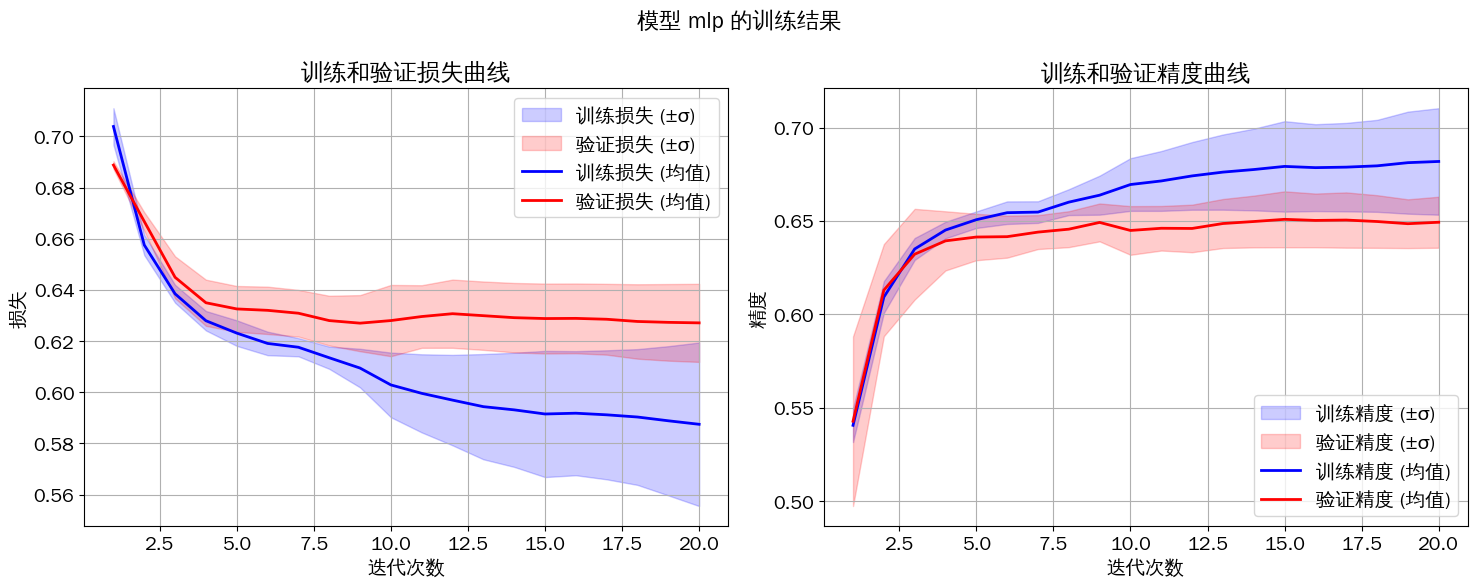

In [29]:
model_accuracies['mlp'] = plot_training_results(model_name='mlp', save_path='pics/mlp_training_results.png')

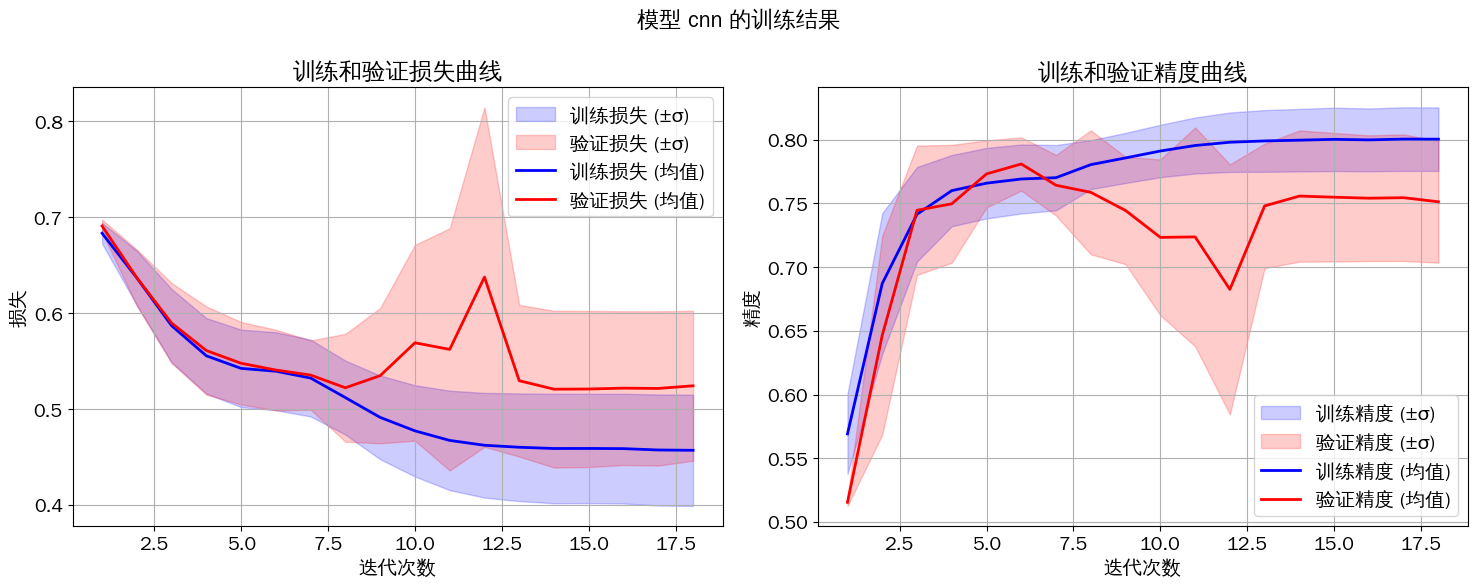

In [32]:
model_accuracies['cnn'] = plot_training_results(model_name='cnn', save_path='pics/cnn_training_results.png')

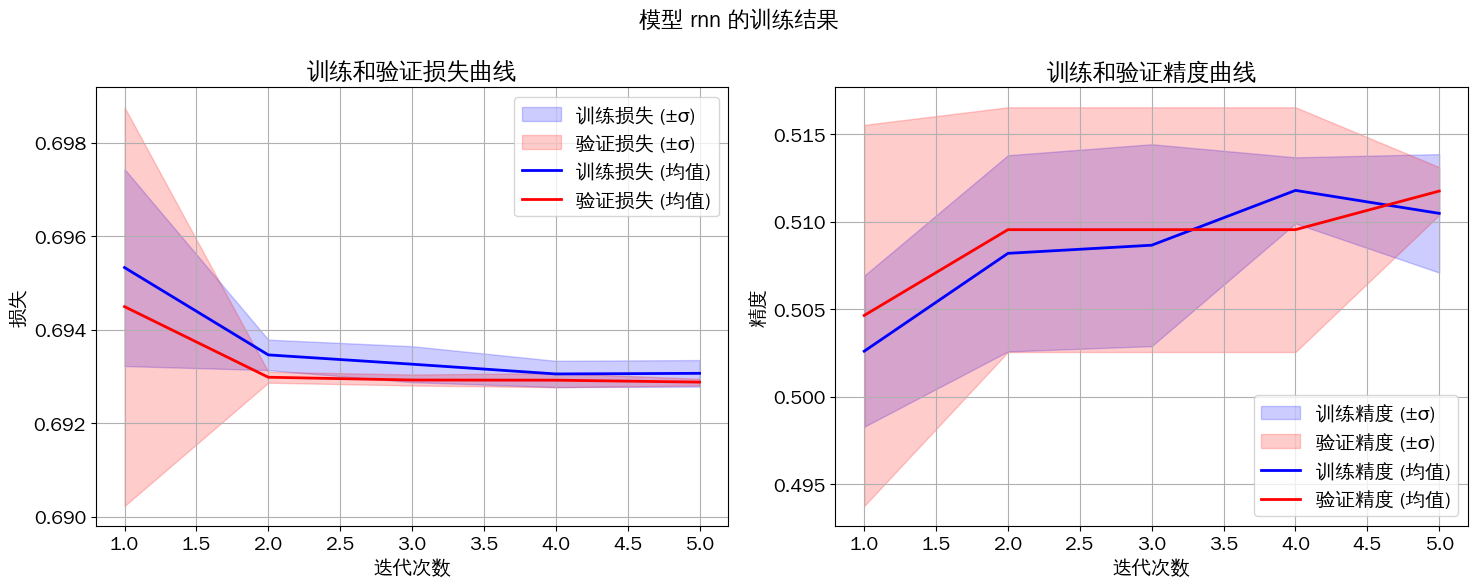

In [33]:
model_name = 'rnn'
model_accuracies[model_name] = plot_training_results(model_name=model_name, save_path=f'pics/{model_name}_training_results.png')

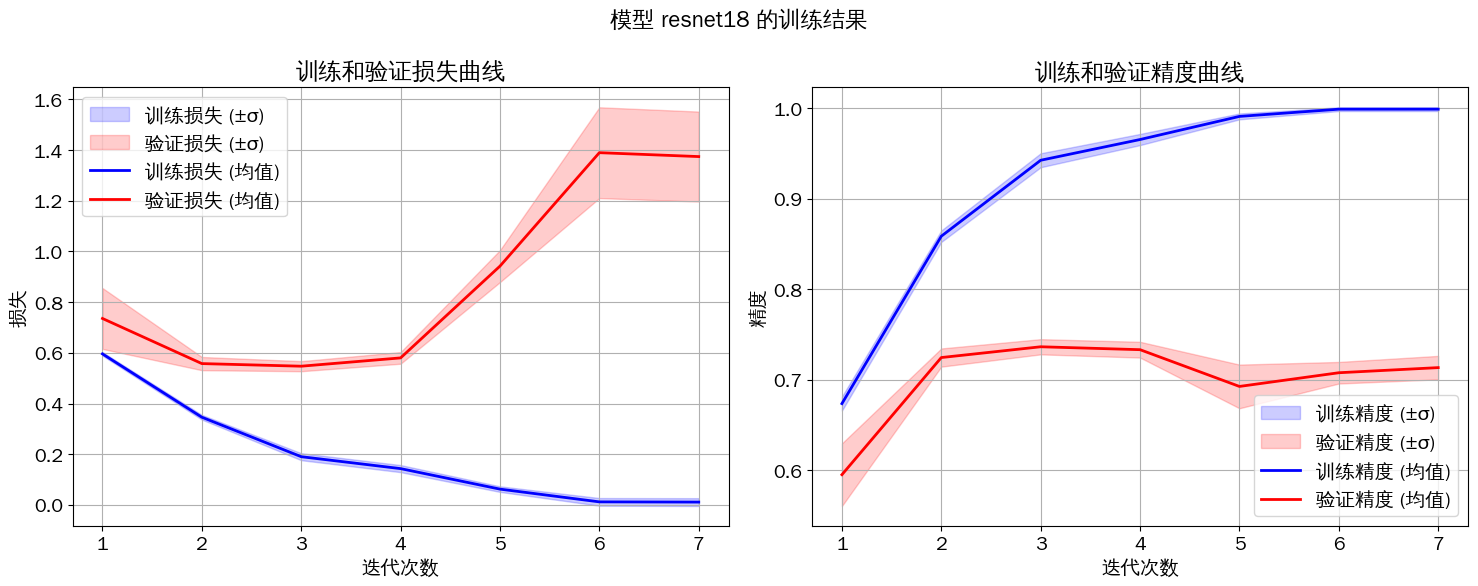

In [34]:
model_name = 'resnet18'
model_accuracies[model_name] = plot_training_results(model_name=model_name, save_path=f'pics/{model_name}_training_results.png')